In [2]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
import os
import logging
import json
import random

import numpy as np
import json
from tqdm.notebook import tqdm
from sklearn.metrics import roc_curve, auc

import matplotlib.pyplot as plt
import pandas as pd

# Assess cup circuit

The purpose of this notebook is to assess the cup circuit based on output accuracy.

If we have isolated the Cup Circuit and set it to the identity matrix, then TinyCLIP will be unable to classify cups but should retain performance on everything else.

The isolated Cup Circuit should classify cups but have poor performance on non-cups.

*To do: ROC curves.* 



## Get TinyCLIP accuracy given a model

Function to get accuracy on cup and non-cup classification. Get accuracy of a vanilla net. Do top 5 classification.

In [3]:
# Load imagenet


# Path to your imagenet_class.json file
json_file_path = '/home/mila/s/sonia.joseph/ViT-Planetarium/my_draft/test_nbs/imagenet_class_index.json'
imagenet_path = '/network/datasets/imagenet.var/imagenet_torchvision/val/'

# Load the JSON file into a Python dictionary
with open(json_file_path, 'r') as file:
    num_to_word_dict = json.load(file)

# Create a reverse dictionary for word to number mapping
word_to_num_dict = {}
for num, words in num_to_word_dict.items():
    for word in words:  # Assuming each entry in num_to_word_dict is a list of words
        word_to_num_dict[word] = num

# Function to get the class name from a label
def get_class_name(label):
    # Assuming the label maps to a list of class names
    return num_to_word_dict.get(str(label), ["Unknown label"])[1]

# Function to get the label from a class name
def get_label(class_name):
    return word_to_num_dict.get(class_name, "Unknown class name")

# Get class names
imagenet_class_nums = np.arange(0, 1000, 1)
imagenet_class_names = ["{}".format(get_class_name(i)) for i in imagenet_class_nums]

# Set the seed. You don't need indices if data is loaded in same order every time.
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

data_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])


# Create 500 random samples from the ImageNet dataset
# num_samples = 500
# random_indices = np.random.choice(len(imagenet_data), num_samples, replace=False)

# Save the order of these indices
# np.save('imagenet_sample_indices.npy', random_indices)

# Function to load images based on saved order
def load_images_in_order(indices_path, imagenet_dataset):
    indices = np.load(indices_path)
    subset_dataset = Subset(imagenet_dataset, indices)
    data_loader = DataLoader(subset_dataset, batch_size=1)
    return data_loader

imagenet_data = datasets.ImageFolder(imagenet_path, transform=data_transforms)

# Example of how to use the function
data_loader = load_images_in_order('imagenet_sample_indices.npy', imagenet_data)


# Load the ImageNet dataset
batch_size = 1
imagenet_data = datasets.ImageFolder(imagenet_path, transform=data_transforms)
data_loader = load_images_in_order('imagenet_sample_indices.npy', imagenet_data)




In [4]:
from transformers import CLIPProcessor, CLIPModel

model = CLIPModel.from_pretrained("wkcn/TinyCLIP-ViT-8M-16-Text-3M-YFCC15M")
processor = CLIPProcessor.from_pretrained("wkcn/TinyCLIP-ViT-8M-16-Text-3M-YFCC15M", do_rescale=False) # Make sure the do_rescale is false for pytorch datasets


`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.


In [42]:
cup_classes = [
    "measuring_cup",
    "coffee_mug",
    "water_jug",
    "whiskey_jug",
    "beer_bottle",
    "pill_bottle",
    "pop_bottle",
    "water_bottle",
    "wine_bottle",
    "washbasin",
    "beaker",
    "vase",
    "cauldron",
    "coffeepot",
    "teapot",
    "barrel",
    "bathtub",
    "bucket",
    "ladle",
    "mortar",
    "pitcher",
    "tub",
    "mixing_bowl",
    "soup_bowl",
    "Petri dish",
    "milk_can",
    "beer_glass",
    "goblet",
    "cocktail_shaker",
    "saltshaker",
    "pot",
    "thimble",
    "hot_pot",
    "trifle",
    "consomme",
    "espresso",
    "red_wine",
    "cup",
    "eggnog"
]

dog_classes = [
    "chihuahua",
    "japanese_spaniel",
    "maltese_dog",
    "pekinese",
    "shih-tzu",
    "blenheim_spaniel",
    "papillon",
    "toy_terrier",
    "rhodesian_ridgeback",
    "afghan_hound",
    "basset",
    "beagle",
    "bloodhound",
    "bluetick",
    "black-and-tan_coonhound",
    "walker_hound",
    "english_foxhound",
    "redbone",
    "borzoi",
    "irish_wolfhound",
    "italian_greyhound",
    "whippet",
    "ibizan_hound",
    "norwegian_elkhound",
    "otterhound",
    "saluki",
    "scottish_deerhound",
    "weimaraner",
    "staffordshire_bullterrier",
    "american_staffordshire_terrier",
    "bedlington_terrier",
    "border_terrier",
    "kerry_blue_terrier",
    "irish_terrier",
    "norfolk_terrier",
    "norwich_terrier",
    "yorkshire_terrier",
    "wire-haired_fox_terrier",
    "lakeland_terrier",
    "sealyham_terrier",
    "airedale",
    "cairn",
    "australian_terrier",
    "dandie_dinmont",
    "boston_bull",
    "miniature_schnauzer",
    "giant_schnauzer",
    "standard_schnauzer",
    "scotch_terrier",
    "tibetan_terrier",
    "silky_terrier",
    "soft-coated_wheaten_terrier",
    "west_highland_white_terrier",
    "lhasa",
    "flat-coated_retriever",
    "curly-coated_retriever",
    "golden_retriever",
    "labrador_retriever",
    "chesapeake_bay_retriever",
    "german_short-haired_pointer",
    "vizsla",
    "english_setter",
    "irish_setter",
    "gordon_setter",
    "brittany_spaniel",
    "clumber",
    "english_springer",
    "welsh_springer_spaniel",
    "cocker_spaniel",
    "sussex_spaniel",
    "irish_water_spaniel",
    "kuvasz",
    "schipperke",
    "groenendael",
    "malinois",
    "briard",
    "kelpie",
    "komondor",
    "old_english_sheepdog",
    "shetland_sheepdog",
    "collie",
    "border_collie",
    "bouvier_des_flandres",
    "rottweiler",
    "german_shepherd",
    "doberman",
    "miniature_pinscher",
    "greater_swiss_mountain_dog",
    "bernese_mountain_dog",
    "appenzeller",
    "entlebucher",
    "boxer",
    "bull_mastiff",
    "tibetan_mastiff",
    "french_bulldog",
    "great_dane",
    "saint_bernard",
    "eskimo_dog",
    "malamute",
    "siberian_husky"
]


In [78]:
# Cache average dog activations
import os
import pandas as pd

num_layers = 10
layer_types = ['fc1', 'fc2']

# Create an empty DataFrame to store the results
all_layers_avg_dog_activation = pd.DataFrame()

for layer_num in range(num_layers):
    for layer_type in layer_types:
        loaded = load_cached_act(layer_num, layer_type)
        avg_dog_activation = loaded[loaded['class_name'].isin(dog_classes)].groupby('neuron_idx')['activation_value'].mean().reset_index()
        avg_dog_activation['layer_num'] = layer_num
        avg_dog_activation['layer_type'] = layer_type
        all_layers_avg_dog_activation = pd.concat([all_layers_avg_dog_activation, avg_dog_activation])

# Reset index of the final DataFrame
all_layers_avg_dog_activation.reset_index(drop=True, inplace=True)

save_path = '/network/scratch/s/sonia.joseph/clip_mechinterp/tinyclip/mini_dataset/'
file_name_to_save = 'avg_dog_activations.parquet'
all_layers_avg_dog_activation.to_parquet(os.path.join(save_path, file_name_to_save))


In [84]:
all_layers_avg_dog_activation


,neuron_idx,activation_value,layer_num,layer_type
0,0,-1.155099,0,fc1
1,1,-1.504439,0,fc1
2,2,-0.001310,0,fc1
3,3,0.041977,0,fc1
4,4,-1.389680,0,fc1
...,...,...,...,...
12795,251,-0.006281,9,fc2
12796,252,-0.028464,9,fc2
12797,253,-0.075678,9,fc2
12798,254,0.078801,9,fc2


In [87]:

def get_resampling_activation(df, neuron_idx, layer_num, layer_type):
    """
    Retrieve the activation value for a specific neuron index, layer number, and layer type.

    Args:
    df (DataFrame): The DataFrame containing the neuron activations.
    neuron_idx (int): The index of the neuron.
    layer_num (int): The layer number.
    layer_type (str): The type of the layer (e.g., 'fc1', 'fc2').

    Returns:
    float: The activation value, or None if not found.
    """
    result = df[(df['neuron_idx'] == neuron_idx) & 
                (df['layer_num'] == layer_num) & 
                (df['layer_type'] == layer_type)]

    if not result.empty:
        return result['activation_value'].iloc[0]
    else:
        return None
    
act = get_resampling_activation(all_layers_avg_dog_activation, 0, 0, 'fc1')


In [89]:
save_path = '/network/scratch/s/sonia.joseph/clip_mechinterp/tinyclip/mini_dataset/'
file_name_to_save = 'avg_dog_activations.parquet'


# Load the average dog activations
avg_dog_activations = pd.read_parquet(os.path.join(save_path, file_name_to_save))

## Get ROC Curves

In [6]:
def plot_roc_curve(fpr, tpr, roc_auc, title):
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc="lower right")
    plt.show()


def is_cup_class(class_name):
    return class_name in cup_classes


In [7]:
def calculate_roc_and_accuracy_for_top5_subsets(data_loader, model, processor, is_cup_class):
    model.eval()
    y_true = []
    y_scores = []
    correct_predictions = 0
    total_predictions = 0

    with torch.no_grad():
        for images, labels in tqdm(data_loader):
            # Process the images and get model outputs
            inputs = processor(text=imagenet_class_names, images=images, return_tensors="pt", padding=True)
            outputs = model(**inputs)
            logits = outputs.logits_per_image

            # Check if true label is in top 5 predictions
            top5_preds = logits.topk(5).indices.squeeze(0).tolist()
            is_top5 = labels.item() in top5_preds

            actual_class_name = get_class_name(labels.item())
            if is_cup_class(actual_class_name):
                y_true.append(1)  # Label 1 for cup class instances
                y_scores.append(is_top5)
                correct_predictions += is_top5
                total_predictions += 1

    # Compute ROC curve
    fpr, tpr, thresholds = roc_curve(y_true, y_scores)
    roc_auc = auc(fpr, tpr)

    # Calculate accuracy
    accuracy = correct_predictions / total_predictions if total_predictions > 0 else 0

    return fpr, tpr, roc_auc, accuracy

# Run for cup classes
fpr_cup, tpr_cup, roc_auc_cup, accuracy_cup = calculate_roc_and_accuracy_for_top5_subsets(data_loader, model, processor, lambda x: x in cup_classes)
print(f"Cup Class - Top-5 ROC AUC: {roc_auc_cup:.2f}, Top-5 Accuracy: {accuracy_cup:.2f}")
plot_roc_curve(fpr_cup, tpr_cup, roc_auc_cup, 'ROC for Top-5 Predictions in Cup Classes')

# Run for non-cup classes
fpr_non_cup, tpr_non_cup, roc_auc_non_cup, accuracy_non_cup = calculate_roc_and_accuracy_for_top5_subsets(data_loader, model, processor, lambda x: x not in cup_classes)
print(f"Non-Cup Class - Top-5 ROC AUC: {roc_auc_non_cup:.2f}, Top-5 Accuracy: {accuracy_non_cup:.2f}")
plot_roc_curve(fpr_non_cup, tpr_non_cup, roc_auc_non_cup, 'ROC for Top-5 Predictions in Non-Cup Classes')


  0%|          | 0/500 [00:00<?, ?it/s]

KeyboardInterrupt: 

## Write function to ablate circuit given a list of MLP neurons

Ablate list, then get accuracy on cups + non-cups.

In [19]:
# Create df of logit differences for all layers (fc1 + f2)
def load_logit_diff_dict(layer_num, neuron_type, layer_type=None):
    load_dir = f'/network/scratch/s/sonia.joseph/clip_mechinterp/tinyclip/logit_differences/cup_logits'

    if not layer_type:
        file_name = f'neuron_dict_{layer_num}_{neuron_type}.npy'
    else:
        file_name = f'neuron_dict_{layer_num}_{neuron_type}_{layer_type}.npy'
    

    neuron_dict = np.load(f'{load_dir}/{file_name}', allow_pickle=True).item()

    # Get average of every entry in neuron_dict
    # avgs = [np.mean(neuron_dict[key]) for key in neuron_dict.keys()]
    return neuron_dict

# Create df of dog ablation values
def filter_neurons_by_threshold(neuron_dict, threshold):
    filtered_dict = {neuron: np.mean(values) for neuron, values in neuron_dict.items() if np.mean(values) < threshold}
    return filtered_dict

# num_layers = 10  # Replace with the actual number of layers
# neuron_type = 'cups'  # or any other neuron type
# layer_type = None  # or specify the layer type if needed
# threshold = 0.5  # Set your threshold value

# # Example for layer_num = 1 (you can loop over layers if needed)
# layer_num = 1
# neuron_dict = load_logit_diff_dict(layer_num, neuron_type, layer_type)

# # Calculating average logit values and filtering
# filtered_neurons = filter_neurons_by_threshold(neuron_dict, threshold)


# # Assuming there are N layers
# num_layers = 10  # Replace 12 with the actual number of layers
# neuron_type = 'cups'  # or any other neuron type you're interested in
# layer_type = None  # or specify the layer type if needed

# # Initialize a list to store averages for each layer

# # Initialize lists to store averages for each layer
# avgs_fc1 = []
# avgs_fc2 = []

# for layer_num in range(0, num_layers):
#     avgs_fc1.append(load_logit_diff_dict(layer_num, neuron_type, None))
#     # avgs_fc2.append(load_logit_diff_dict(layer_num, neuron_type, 'fc2'))

# # Now, create a DataFrame
# df = pd.DataFrame({
#     'Layer_Num': range(0, num_layers), 
#     'Average_Logit_Differences_FC1': avgs_fc1,
#     # 'Average_Logit_Differences_FC2': avgs_fc2
# })


In [27]:
def load_logit_diff_dict(layer_num, neuron_type, layer_type):
    load_dir = '/network/scratch/s/sonia.joseph/clip_mechinterp/tinyclip/logit_differences/cup_logits'
    if layer_type is None:
        file_name = f'neuron_dict_{layer_num}_{neuron_type}.npy'
    else:
        file_name = f'neuron_dict_{layer_num}_{neuron_type}_{layer_type}.npy'
        
    neuron_dict = np.load(f'{load_dir}/{file_name}', allow_pickle=True).item()
    return neuron_dict

In [43]:
import numpy as np



def calculate_average_logit_values(num_layers, neuron_type, layer_types):
    all_layers_avg_logits = {}
    for layer_num in range(num_layers):
        all_layers_avg_logits[layer_num] = {}
        for layer_type in layer_types:
            neuron_dict = load_logit_diff_dict(layer_num, neuron_type, layer_type)
            avg_logits = {neuron: np.mean(values) for neuron, values in neuron_dict.items()}
            if layer_type == None:
                layer_type = 'fc1'
            all_layers_avg_logits[layer_num][layer_type] = avg_logits

    return all_layers_avg_logits

def filter_dict_by_threshold(nested_dict, threshold, below_threshold=True):
    filtered_dict = {}
    for layer, layer_data in nested_dict.items():
        filtered_dict[layer] = {}
        for module, neuron_data in layer_data.items():
            if below_threshold:
                filtered_dict[layer][module] = {neuron: avg for neuron, avg in neuron_data.items() if avg < threshold}
            else:
                filtered_dict[layer][module] = {neuron: avg for neuron, avg in neuron_data.items() if avg > threshold}
    return filtered_dict

num_layers = 10
neuron_type = 'cups'
layer_types = [None, 'fc2']
threshold = -50 # Define your threshold

# Calculate average logit values for each neuron in each module and layer
avg_logit_values = calculate_average_logit_values(num_layers, neuron_type, layer_types)

# Filter the dictionary based on the threshold
filtered_logit_values = filter_dict_by_threshold(avg_logit_values, threshold, below_threshold=True)

# Now, filtered_logit_values contains the data structured by layer and module, filtered by the threshold.


In [38]:
filtered_logit_values

{0: {'fc1': {}, 'fc2': {}},
 1: {'fc1': {}, 'fc2': {}},
 2: {'fc1': {}, 'fc2': {}},
 3: {'fc1': {}, 'fc2': {}},
 4: {'fc1': {}, 'fc2': {}},
 5: {'fc1': {161: -95.1619978249073, 847: -76.28898281604052},
  'fc2': {161: -60.599219128489494}},
 6: {'fc1': {333: -58.20064886473119}, 'fc2': {}},
 7: {'fc1': {128: -149.6555608510971,
   150: -107.33996614813805,
   734: -51.00202553905547},
  'fc2': {128: -136.68424516916275, 150: -88.7842807173729}},
 8: {'fc1': {90: -51.954936385154724, 461: -102.86492738872766}, 'fc2': {}},
 9: {'fc1': {682: -66.1489588022232, 887: -53.825907818973064}, 'fc2': {}}}

In [56]:
# # Get average of dog neurons from cached activations
# def load_cached_act(layer_num, layer_type, save_path = '/network/scratch/s/sonia.joseph/clip_mechinterp/tinyclip/mini_dataset/'):
#     """
#     Load cached activations and calculate per-neuron z-scores.
#     """

#     file_name = f'mlp_{layer_type}_{layer_num}.npz'
#     loaded = pd.read_parquet(os.path.join(save_path, file_name))

#     return loaded
    
    
# layer_num = 7
# layer_type = 'fc1'
# loaded = load_cached_act(layer_num, layer_type)
# avg_dog_activation = loaded[loaded['class_name'].isin(dog_classes)].groupby('neuron_idx')['activation_value'].mean()

In [63]:
def logit_metric(logits, cup_indices):
    # Convert cup_indices to a tensor if it's a list
    cup_indices_tensor = torch.tensor(cup_indices, dtype=torch.long)

    # Create a boolean mask for all logits: False for cup indices, True for others

    mask = torch.ones(logits.shape[1], dtype=torch.bool)  # All True initially
    mask[cup_indices_tensor] = False  # Set False for cup indices

    # Extract cup logits
    cup_logit = logits[:, cup_indices_tensor]

    # Extract non-cup logits using the inverted mask
    non_cup_logit = logits[:, mask]

    diff = logsumexp(cup_logit, axis=1).mean() - logsumexp(non_cup_logit, axis=1).mean()

    return diff

In [138]:
# Filter logit difference df by threshold
import copy
from PIL import Image

def create_custom_hook(neuron_idx, new_value):
    # This is the actual hook function
    def custom_forward_hook(module, input, output):
        # Modify the output for the specified neuron
        output[:, :, neuron_idx] = new_value
        return output
    return custom_forward_hook


def transform_images(img_directory, image_path):
    image = Image.open(os.path.join(img_directory, image_path)).convert('RGB')

    # Define the transformation
    transform = transforms.Compose([
        transforms.Resize((224, 224)),  # Resize to the input size expected by the CLIP model
        transforms.ToTensor(),          # Convert to PyTorch Tensor
        # transforms.Normalize(mean=[0.48145466, 0.4578275, 0.40821073], std=[0.26862954, 0.26130258, 0.27577711])  # Normalize (specific to CLIP)
    ])

    # Apply the transformation
    image_tensor = transform(image)

    # Add a batch dimension
    image_tensor = image_tensor.unsqueeze(0) 
    return image_tensor


def ablate_subgraph(filtered_logit_values, model):
    ablated_model = copy.deepcopy(model)
    hook_handles = []
    for layer_num, layer_data in filtered_logit_values.items():
        for layer_type, neurons in layer_data.items():
            for neuron_idx, new_value in neurons.items():
                # print(f'Layer {layer_num}, {layer_type}, Neuron {neuron_idx}')
                new_value = get_resampling_activation(avg_dog_activations, neuron_idx, layer_num, layer_type)
                custom_hook_function = create_custom_hook(neuron_idx, new_value)
                module = getattr(ablated_model.vision_model.encoder.layers[layer_num].mlp, layer_type)
                hook_handle = module.register_forward_hook(custom_hook_function)
                hook_handles.append(hook_handle)


    cup_dir = '/home/mila/s/sonia.joseph/CLIP_mechinterp/sample_images/cup_images'
    new_cup_images = ['beer.png','many_cups.png','blue_cup.png','two_cups.png','tub.png']
    new_cup_images = [transform_images(cup_dir, image_path) for image_path in new_cup_images]

    total_vanilla_diff = []
    total_abl_diff = []
    
    for image in new_cup_images:
        inputs = processor(text=imagenet_class_names, images=image, return_tensors="pt", padding=True)
        ablated_outputs = ablated_model(**inputs)
        logits_per_image = ablated_outputs.logits_per_image
        ablated_logits = logits_per_image.detach().numpy()

        # Vanilla logits
        vanilla_outputs = model(**inputs)
        vanilla_logits_per_image = vanilla_outputs.logits_per_image
        vanilla_logits = vanilla_logits_per_image.detach().numpy()

        vanilla_diff = logit_metric(vanilla_logits, cup_indices)
        abl_diff = logit_metric(ablated_logits, cup_indices)

        # print('vanilla diff', vanilla_diff)
        # print('abl diff', abl_diff)

        total_vanilla_diff.append(vanilla_diff)
        total_abl_diff.append(abl_diff)

    return np.mean(total_vanilla_diff), np.mean(total_abl_diff), ablated_model


In [139]:
def percent_change(old_value, new_value):
    return (new_value - old_value) / np.abs(old_value) * 100

In [140]:
from scipy.special import logsumexp

cup_indices = [imagenet_class_names.index(cup_name) for cup_name in cup_classes if cup_name in imagenet_class_names]

# vanilla_diff = logit_metric(vanilla_logits, cup_indices)
# abl_diff = logit_metric(ablated_logits, cup_indices)

# pc = percent_change(vanilla_diff, abl_diff)

# print("percent change", pc)

In [141]:
# Get accuracy

def get_accuracy(data_loader, model, processor):
    fpr_cup, tpr_cup, roc_auc_cup, accuracy_cup = calculate_roc_and_accuracy_for_top5_subsets(data_loader, ablated_model, processor, lambda x: x in cup_classes)
    print(f"Cup Class - Top-5 ROC AUC: {roc_auc_cup:.2f}, Top-5 Accuracy: {accuracy_cup:.2f}")
    plot_roc_curve(fpr_cup, tpr_cup, roc_auc_cup, 'ROC for Top-5 Predictions in Cup Classes')

    # Run for non-cup classes
    fpr_non_cup, tpr_non_cup, roc_auc_non_cup, accuracy_non_cup = calculate_roc_and_accuracy_for_top5_subsets(data_loader, ablated_model, processor, lambda x: x not in cup_classes)
    print(f"Non-Cup Class - Top-5 ROC AUC: {roc_auc_non_cup:.2f}, Top-5 Accuracy: {accuracy_non_cup:.2f}")
    plot_roc_curve(fpr_non_cup, tpr_non_cup, roc_auc_non_cup, 'ROC for Top-5 Predictions in Non-Cup Classes')

    return accuracy_cup, accuracy_non_cup

  0%|          | 0/10 [00:00<?, ?it/s]

threshold -100


  0%|          | 0/500 [00:00<?, ?it/s]

Cup Class - Top-5 ROC AUC: nan, Top-5 Accuracy: 0.70


/home/mila/s/sonia.joseph/ViT-Planetarium/env/lib/python3.7/site-packages/sklearn/metrics/_ranking.py:992: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  UndefinedMetricWarning,


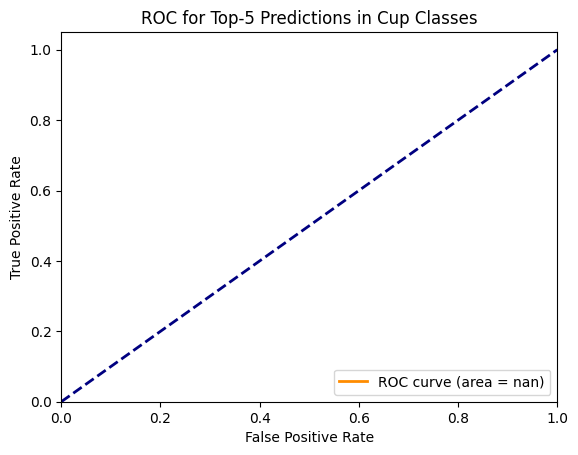

  0%|          | 0/500 [00:00<?, ?it/s]

In [142]:
# Try with different thresholds
thresholds = [-100, -50, -25, -10, -5, 0, 5, 10, 25, 50]

total_percents = []
total_acc_cup = []
total_acc_non_cup = []

for t in tqdm(thresholds):
    print('threshold', t)
    if t <= 0:
        filtered_logit_values = filter_dict_by_threshold(avg_logit_values, t, below_threshold=True)
    else:
        filtered_logit_values = filter_dict_by_threshold(avg_logit_values, t, below_threshold=False)
    vanilla_diff, ablated_diff, ablated_model = ablate_subgraph(filtered_logit_values, model)
    pc = percent_change(vanilla_diff, ablated_diff)
    total_percents.append(pc)
    acc_cup, accuracy_non_cup = get_accuracy(data_loader, ablated_model, processor)
    print('accuracy cup', acc_cup)
    print('accuracy non cup', accuracy_non_cup)

    total_acc_cup.append(acc_cup)
    total_acc_non_cup.append(accuracy_non_cup)



In [ ]:
plt.figure()
plt.plot(thresholds, total_percents)

## Write function to isolate a subgraph given a list of neurons

Isolate subgraph by using resampling activations on non-subgraph neurons. Then run cup and non-cup classification.